<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Timeseries-Analysis-Using-Gaussian-Process-Regression" data-toc-modified-id="Timeseries-Analysis-Using-Gaussian-Process-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Timeseries Analysis Using Gaussian Process Regression</a></span></li><li><span><a href="#1.-Background" data-toc-modified-id="1.-Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1. Background</a></span></li><li><span><a href="#2.-GP-Regression-Example" data-toc-modified-id="2.-GP-Regression-Example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2. GP Regression Example</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Periodicity-estimation-using-Gaussian-Process-Regression" data-toc-modified-id="Periodicity-estimation-using-Gaussian-Process-Regression-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Periodicity estimation using Gaussian Process Regression</a></span></li></ul></li></ul></li><li><span><a href="#3.-Results" data-toc-modified-id="3.-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>3. Results</a></span><ul class="toc-item"><li><span><a href="#3.1.-Oscillations-in-Cloud-Size-Distribution" data-toc-modified-id="3.1.-Oscillations-in-Cloud-Size-Distribution-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>3.1. Oscillations in Cloud Size Distribution</a></span></li><li><span><a href="#3.2.-Pulsating-Plumes" data-toc-modified-id="3.2.-Pulsating-Plumes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>3.2. Pulsating Plumes</a></span></li></ul></li><li><span><a href="#4.-References" data-toc-modified-id="4.-References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>4. References</a></span></li></ul></div>

In [1]:
from IPython.display import Image

# Timeseries Analysis Using Gaussian Process Regression

# 1. Background

 A *Gaussian Process* is *a collection of random variables, any finite number of which have a joint Gaussian distribution*.
 
 A Gaussian process is completely specified by its mean function and covariance function. The mean function $m(\boldsymbol{x})$ reflects the expected function value at imput $\boldsymbol{x}$: $$m(\boldsymbol{x}) = \mathbb{E}[f(\boldsymbol{x})],$$ that is, the average of all functions in the distribution evaluated at input $\boldsymbol{x}$. The prior mean is often set to $m(\boldsymbol{x}) = 0$ in order to avoid expensive posterior computations and only do inference via the covariance function. The covariance function $k(\boldsymbol{x}, \boldsymbol{x'})$ models the dependence between the fuction values at different input points $\boldsymbol{x}$ and $\boldsymbol{x'}$: $$k(\boldsymbol{x}, \boldsymbol{x'}) = \mathbb{E}[(f(\boldsymbol{x}) - m(\boldsymbol{x}))(f(\boldsymbol{x'}) - m(\boldsymbol{x'}))]$$ and we can finally write the *Gaussian process* as $$f(\boldsymbol{x}) \approx \mathcal{GP}(m(\boldsymbol{x}), k(\boldsymbol{x}, \boldsymbol{x'})).$$
 
 A simple example of a Gaussian process can be obtained from a Bayesian linear regression model $f(\boldsymbol{x}) = \phi(\boldsymbol{x})^\intercal \boldsymbol{w}$ with prior $\boldsymbol{w} \approx \mathcal{N}(0, \sigma_p)$. Then the mean and the covariance of the model can be written as $$\mathbb{E}[f(\boldsymbol{x})] = \phi(\boldsymbol{x})^\intercal \mathbb{E}[\boldsymbol{w}] = 0,$$ $$\mathbb{E}[f(\boldsymbol{x})f(\boldsymbol{x'})] = \phi(\boldsymbol{x})^\intercal \mathbb{E}[\boldsymbol{w}\boldsymbol{w}^\intercal] \phi(\boldsymbol{x'}) = \phi(\boldsymbol{x})^\intercal \sigma_p \phi(\boldsymbol{x'}).$$
 
 Thus $f(\boldsymbol{x})$ and $f(\boldsymbol{x'})$ are jointly Gaussian with $0$ mean and covariance given by the second equation above. The covariance between pairs of random variables is specified by the aptly named *covariance function* $k(\boldsymbol{x}, \boldsymbol{x'})$. The symbol $k(\boldsymbol{x}, \boldsymbol{x'})$ is because the covariance function is often referred to as the *kernel*. We will use the two terms interchangeably.
 
 The most popular choice of a kernel is the *radial-basis function* kernel, also called the *squared exponential* (SE) kernel, $$k(x_i, x_j) = \exp \left( - \frac{1}{2} d \left( \frac{x_i}{l}, \frac{x_j}{l} \right) \right) \,,$$ which is parameterized by a length-scale parameter $l < 0$. Sometimes it is called the *Gaussian* kernel, although I find it a bit confusing at times. It is by far the most widely used covariance function in the machine learning studies, and is infinitely differentiable and very smooth. 
 
 For the sake of this notebook, we will also be using the *periodic* kernel, $$k(x_i, x_j) = \exp \left(-2 \frac{\sin^2 \left(\frac{\pi}{T} d(x_i, x_j) \right)}{l^2} \right) \,,$$ which is parameterized by a length scale $l > 0$ and a periodicity $T > 0$.
 
 Also, we will also be using the *rational quadratic* (RQ) kernel $$k(x_i, x_j) = \left( 1 - \frac{d(x_i, x_j)^2}{2 \alpha l^2} \right)^{-\alpha} \,,$$ where an additional *scale mixture* parameter $\alpha > 0$ is used to construct an infinite sum (mixture) of SE kernels at different length scales. The RQ covariance function becomes the SE covariance function with a length scale of $l$ for $\alpha \to \infty$.
 
 In order to make predictions given the covariance function(s), we can draw outputs for a finite number of points by using a multivariate Gaussian distribution with a covariance matrix generated by the kernel. Let $\boldsymbol{X_*}$ be a matrix with on each row a new input point $\boldsymbol{x}^*_i$ for an arbitrary $i$. Then the covariances between all inputs in $\boldsymbol{X_*}$ corresponds to: 
 
 $$K(\boldsymbol{X_*}, \boldsymbol{X_*}) = 
    \begin{bmatrix}
        k(\boldsymbol{x^*_1}, \boldsymbol{x^*_1}) & k(\boldsymbol{x^*_1}, \boldsymbol{x^*_2}) & \dots & k(\boldsymbol{x^*_1}, \boldsymbol{x^*_n}) \\ 
        k(\boldsymbol{x^*_2}, \boldsymbol{x^*_1}) & k(\boldsymbol{x^*_2}, \boldsymbol{x^*_2}) & \dots & k(\boldsymbol{x^*_2}, \boldsymbol{x^*_n}) \\
        \vdots & \vdots & \ddots & \vdots \\
        k(\boldsymbol{x^*_n}, \boldsymbol{x^*_1}) & k(\boldsymbol{x^*_n}, \boldsymbol{x^*_2}) & \dots & k(\boldsymbol{x^*_n}, \boldsymbol{x^*_n})
    \end{bmatrix}.$$
    
 We can now sample the values of $f$ at each set of input points $\boldsymbol{X_*}$ from the $\mathcal{GP}$ by sampling from a multivariate normal distribution $$\boldsymbol{f_*} \sim \mathcal{N}(0, K(\boldsymbol{X_*}, \boldsymbol{X_*}))$$ where $\boldsymbol{f_*} = [f(\boldsymbol{x^*_1}), \dots, f(\boldsymbol{x^*_n})]^\intercal$, where $\boldsymbol{f_*}$ is a sample from the distribution of functions evaluated at the corresponding input point.
 
 Suppose we have made a series of noisy observations $y = f(\boldsymbol{x}) + \epsilon)$ for some observational noise $\epsilon$. Assuming $\epsilon \approx \mathcal{N}(0, \sigma^2_n)$, the prior for these observations becomes $$\text{cov}(\boldsymbol{y}) = K(X, X) + \delta^2_n I.$$ 
 
 Then the joint distribution of the training outputs $\boldsymbol{f}$ and the test outputs $\boldsymbol{f_*}$ according to the prior is 
 $$
 \begin{bmatrix}
     \boldsymbol{y_t} \\ \boldsymbol{f_*}
 \end{bmatrix} = \mathcal{N} \left( 0,
 \begin{bmatrix}
     K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \sigma^2_n & K(\boldsymbol{X_t}, \boldsymbol{X_*}) \\
     K(\boldsymbol{X_*}, \boldsymbol{X_t}) & K(\boldsymbol{X_*}, \boldsymbol{X_*})
 \end{bmatrix} \right)
 $$ where $K(\boldsymbol{X_t}, \boldsymbol{X_t})$ is the covariance between all observed points (or training points), $K(\boldsymbol{X_t}, \boldsymbol{X_*})$ is the covariance between the new observations, $K(\boldsymbol{X_*}, \boldsymbol{X_t})$ is the covariance between the new and old observations, and finally, $K(\boldsymbol{X_*}, \boldsymbol{X_*}$ is the covariance between old and new observed points.
 
 The conditional distribution is then $$\boldsymbol{f_*} \; \mid \; X_t, \boldsymbol{y_t}, X_* \approx \mathcal{N}(\overline{\boldsymbol{f}}_*, \text{cov}(\boldsymbol{f_*})),$$ where $$\overline{\boldsymbol{f}}_* \triangleq \mathbb{E}[\boldsymbol{f_*} \mid X_t, \boldsymbol{y}, X_*] = K(\boldsymbol{X_*}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} \boldsymbol{y},$$ $$\text{cov}(\boldsymbol{f_*}) = K(\boldsymbol{X_*}, \boldsymbol{X_*}) - K(\boldsymbol{X_*}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} K(\boldsymbol{X_t}, \boldsymbol{X_*}).$$
 
 This posterior is also a Gaussian process with mean $$m(\boldsymbol{x}) = K(\boldsymbol{x}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} \boldsymbol{y_t},$$ and kernel $$k_t(\boldsymbol{x}, \boldsymbol{x'}) = k(\boldsymbol{x}, \boldsymbol{x'})- K(\boldsymbol{x}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} K(\boldsymbol{X_t}, \boldsymbol{x'}).$$
 
 Note that for noise-free observations, we can simply omit $\delta^2_n I$ term from above. The two cases will have the solutions of the same shape.
 
 Therefore, having made the initial observations (on *training sets*) and received new observations, we can calculate the four covariance matrices $K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \sigma^2_n$, $K(\boldsymbol{X_t}, \boldsymbol{X_*})$, $K(\boldsymbol{X_*}, \boldsymbol{X_t})$ and $K(\boldsymbol{X_*}, \boldsymbol{X_*})$ to obtain posterior distribution and its kernel. The kernel is usually defined by a few hyperparameters that are inferred from, and only from, the data. For this reason, the bulk of GP regression method is to construct the kernel from possibly a number of covariance functions (in order to encode the prior assumptions about the observation), and obtaining the hyperparameters from the observations. 
 
 Since this is often very challenging, in a real-world scenario, the hyperparameters are obtained by maximizing the (log) marginal likelihood. This is similar to parameter estimatiom by maximum likelihood and is also referred to as type-II maximum likelihood. The log marginal likelihood is defined as $$ \log{p}(\boldsymbol{y} \mid \boldsymbol{X}) = - \frac{1}{2} \boldsymbol{y}^\intercal \boldsymbol{K}^{-1}_y \boldsymbol{y} - \frac{1}{2} \log{| \boldsymbol{K}_y |} - \frac{n}{2} \log{2 \pi},$$ where $K_y = K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \sigma^2_n I$. The first term measures how well the current kernel reproduces $\boldsymbol{y}$, the second term measures the complexity of the model, and the last term is a constant used for normalization. Often (and it is the case for *scikit-learn*) the log marginal likelihood is maximized using a gradient-descent optimization, which is based on the partial derivative of the log marginal likelihood with respect to $\theta$ (i.e. the hyperparameters of the covariance functions, such as the length scale $l$). That is, $$
\begin{align} 
\frac{\partial}{\partial \theta_i} \log{p(\boldsymbol{y} \mid X, \boldsymbol{\theta})} &= \frac{1}{2} \boldsymbol{y}^\intercal \boldsymbol{K}^{-1}_y \boldsymbol{y} - \frac{1}{2} \text{tr} \left( \boldsymbol{K}^{-1}_y \frac{\partial \boldsymbol{K}^{-1}_y}{\partial \theta_i} \right) \\
&= \frac{1}{2} \text{tr} \left( (\boldsymbol{K}^{-1}_y \boldsymbol{y}) (\boldsymbol{K}^{-1}_y \boldsymbol{y})^\intercal) - \boldsymbol{K}^{-1}_y) \frac{\partial \boldsymbol{K}^{-1}_y}{\partial \theta_i} \right)
\end{align}$$

In [2]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic

In [3]:
#---- Plot settings
sns.set_context('paper')
sns.set_style('ticks', 
    {
        'axes.grid': False, 
        'axes.linewidth': '0.75',
        'grid.color': '0.75',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })

 # 2. GP Regression Example
 ### Periodicity estimation using Gaussian Process Regression

 First, we will use a known periodic timeseries $$y(t) = \sin(\frac{2 \pi}{T} t)$$ as an example, where $t$ is time and $T$ is period of oscillation (both in minutes, for simplicity). To make this example more interesting for the sake of Gaussian process regression, we will also add a moderately increasing long-term trend to our timeseries observation.

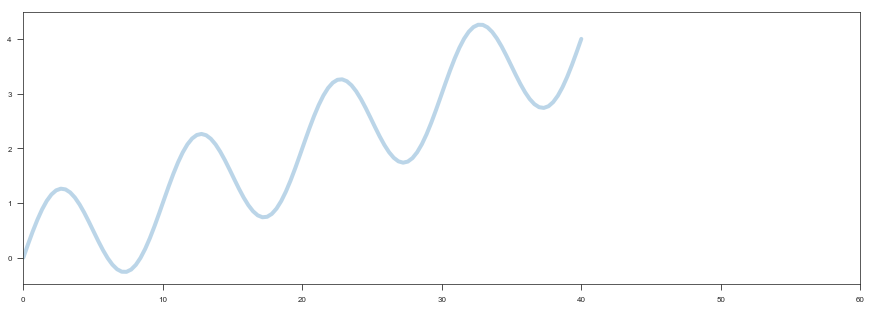

In [4]:
fig = plt.figure(1, figsize=(15, 5))

xi = np.linspace(0, 40, 120)
y = np.sin(xi * (2 * np.pi) / 10) + xi / 10

plt.plot(xi, y, lw=4, alpha=0.3)

plt.xlim([0, 60])
fig.savefig('../png/raw_simple.png')

 Then we add random observational errors to the timeseries data above. For this purpose, we use Numpy's random number generater sampled from a normal distribution of mean $0$ and variance $0.1$ in $x$ and 1 in $y$. This is more or less for simplicity, and repeating the experiment with different samplers (from different probability distributions) does not appear to affect the accuracy of the result.
 
 The errors are added in both dimensions, resulting in $$y(t) = \frac{2 \pi}{T} (t + \epsilon_t) + \epsilon.$$ The observationals errors $\epsilon$ and $\epsilon_t$ can be interpreted as sampling errors, but for this example, I aim to have the magnitude of these errors arbitarily large enough to make it difficult to see the underlying trend.

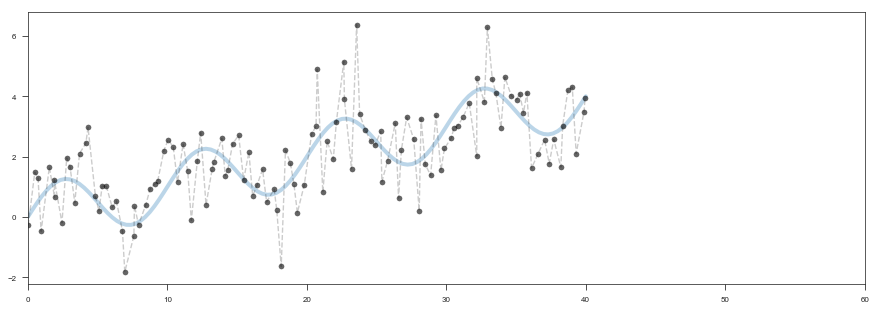

In [24]:
# Plot with random error (in both x and y)
fig = plt.figure(1, figsize=(15, 5))

x_e = xi + np.random.randn(len(xi)) / 10
y_e = y + np.random.randn(len(y))

plt.plot(xi, y, lw=4, alpha=0.3)
plt.plot(x_e, y_e, 'ko', alpha=0.5)
plt.plot(x_e, y_e, 'ko--', alpha=0.2)

plt.xlim([0, 60])
fig.savefig('../png/sine_plus_noise.png')

 While the above plot makes the underlying oscillation somewhat obvious, it is very difficult to see that without knowing the original timeseires distribution. If we are given the following distribution, I'd say we will probably attempt to approximate it with a linear regression, seeing that, by observation, I would highly doubt if there are any oscillatory motions in the observed timeseries data.

(0, 60)

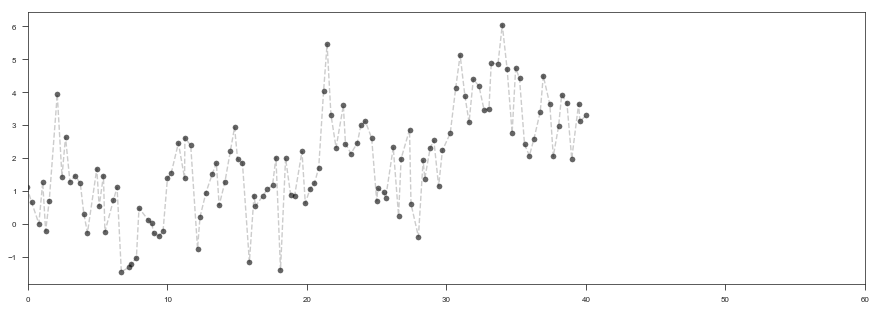

In [6]:
fig = plt.figure(1, figsize=(15, 5))

plt.plot(x_e, y_e, 'ko', alpha=0.5)
plt.plot(x_e, y_e, 'ko--', alpha=0.2)

plt.xlim([0, 60])

 Now, we use Gaussian process regression module from *scikit-learn* to identify the underlying oscillation in our timeseries. Obviously, we will be using a periodic kernel, $$k(x_i, x_j) = \exp \left(-2 \frac{\sin^2 \left(\frac{\pi}{T} d(x_i, x_j) \right)}{l^2} \right) \,,$$ which is parameterized by a length scale $l > 0$ and a periodicity $T > 0$.
 
 We will also be using a radial-basis function kernel, also called the *squared exponential* (SE) kernel, $$k(x_i, x_j) = \exp \left( - \frac{1}{2} d \left( \frac{x_i}{l}, \frac{x_j}{l} \right) \right) \,,$$ which is parameterized by a length-scale parameter $l < 0$. In this case, the SE kernel is used to account for the small increasing trend observed in our timeseries. However, the choice of the SE kernel isn't deliberate, but it is mainly because the SE kernel is most widely used for GP regression and the smooth nature of the covariance function is useful in this case.
 
 Lastly, to account for local variability, we will use the *rational quadratic* (RQ) kernel $$k(x_i, x_j) = \left( 1 - \frac{d(x_i, x_j)^2}{2 \alpha l^2} \right)^{-\alpha} \,,$$ where an additional *scale mixture* parameter $\alpha > 0$ is used to construct an infinite sum (mixture) of SE kernels.

kernel dump:  3.57**2 * RBF(length_scale=57.5) + 0.99**2 * RationalQuadratic(alpha=6.13, length_scale=0.000264) + 0.152**2 * WhiteKernel(noise_level=5.08e-05) + 1.5**2 * ExpSineSquared(length_scale=2.05, periodicity=10)


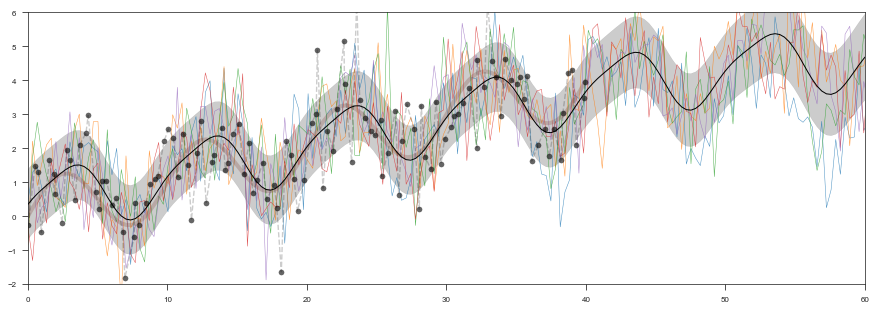

In [25]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-1, 1e3)) \
        + 1.0 * RationalQuadratic(alpha=1e1, alpha_bounds=(1e-2, 1e3), length_scale=1e-1, length_scale_bounds=(1e-5, 1)) \
        + 1.0 * WhiteKernel(noise_level=1e-5) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(1e-2, 1e2), periodicity_bounds=(5, 30))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
X_ = np.array(x_e)
gp.fit(X_[:, None], np.array(y_e))

fig = plt.figure(1, figsize=(15, 5))

X = np.linspace(0, 80, 240)
y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X, y_mean, 'k', lw=1, zorder=9)
plt.fill_between(X, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print('kernel dump: ',gp.kernel_)

y_samples = gp.sample_y(X[:, None], 5)
plt.plot(X, y_samples, lw=0.5, alpha=0.8)

plt.plot(xi, y, lw=4, alpha=0.3)
plt.plot(x_e, y_e, 'ko', alpha=0.5)
plt.plot(x_e, y_e, 'ko--', alpha=0.2)

plt.xlim([0, 60])
plt.ylim([-2, 6])
fig.savefig('../png/process_prediction_simple.png')

 The above plot shows the results of applying Gaussian process regression using *scikit-learn* on our observed timeseries data. The black dots show the timeseries data points, the grey regions denotes the uncertainties involved with the regression, and the coloured lines show a few prior functions. The solid black line is the mean value of such prior functions, which is our *posterior distribution* over fuctions. 
 
 Notice that the uncertainties are reduced closer to some of the observations, but not fully because we believe that the observations are not the exact truth. This gives us quite a bit of flexibility with building the *posterior* distribution, which consists our prediction model through inferenece.
 
 As we can see from the hyperparameters of the posterior distribution (solid black line), GP regression method has dont a good job at retrieving the underlying oscillatory motion with periodicity $T = 9.9 \approx 10$. 
 
 However, it is evident that past the training dataset ($t > 40$ minutes), the predicted model fails at reproducing the long-term increasing trend in our timeseries data. It is possible to further optimize the hyperparameters and get a better model, but for the sake of this example, we choose to keep things simple and focused on our goal, which is to estimate the periodicity in a noisy timeseries data as precisely as possible.
 
 For that purpose, we can de-trend the observed timeseries to remove any long-term increasing (or decreasing) trend. The following figure shows the result of apply GP regression on the de-trended timeseries data.

0.703**2 * RationalQuadratic(alpha=1e+03, length_scale=0.339) + 2.79**2 * WhiteKernel(noise_level=0.0778) + 0.853**2 * ExpSineSquared(length_scale=1.46, periodicity=10.2)


(-2.5, 2.5)

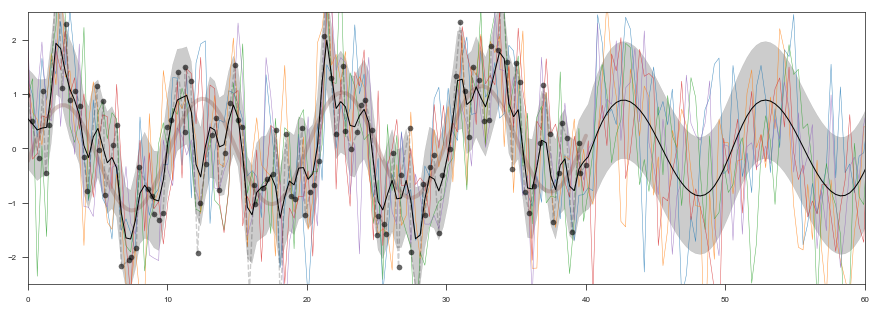

In [8]:
kernel = 1.0 * RationalQuadratic(alpha_bounds=(1e-2, 1e3), length_scale=1e-1, length_scale_bounds=(1e-5, 1e1)) \
        + 1.0 * WhiteKernel(noise_level=1e-2) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(1e-1, 1e2), periodicity_bounds=(5, 30))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

y_d = signal.detrend(y)
y_derr = signal.detrend(y_e)

X_ = np.array(x_e)
gp.fit(X_[:, None], np.array(y_derr))

fig = plt.figure(1, figsize=(15, 5))

X = np.linspace(0, 80, 240)
y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X, y_mean, 'k', lw=1, zorder=9)
plt.fill_between(X, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print(gp.kernel_)

y_samples = gp.sample_y(X[:, None], 5)
plt.plot(X, y_samples, lw=0.5, alpha=0.8)

plt.plot(xi, y_d, lw=4, alpha=0.3)
plt.plot(x_e, y_derr, 'ko', alpha=0.5)
plt.plot(x_e, y_derr, 'ko--', alpha=0.2)

plt.xlim([0, 60])
plt.ylim([-2.5, 2.5])

 De-trending a timeseries data with a long-term trend makes it easier for the GP regression method to identify the underlying oscillation within our noisy data. As previously mentioned, we don't always need to do this, but it makes the optimization step much easier, as we can focus on modelling the periodic motion and the observational noise in the data. However, it has to be mentioned that de-trending the data does not necessarily make the GP regression more accurate, but it makes the periodicity analysis more straightforward.
 
 The resulting period $T = 10$ minutes is exactly the periodicity in the original sine function, which is impressive especially since we have added observational errors in both $x$ and $y$ dimensions. Of course, it is not always the case that we can *exactly* determine the periodicity of the noisy timeseries, but the method seems to yield consistent results, mostly within $5-10 \%$ of the ground truth (10 minutes).
 
 To further show how good the periodicity estimate is with GP regression method, I have plotted the observed timeseries (black dots) and the ground truth (solid blue) as well as the predicted model (solid orange). The predicted model deviates slightly from the wave function, but remains quite close to the ground truth without noise. 

(0, 60)

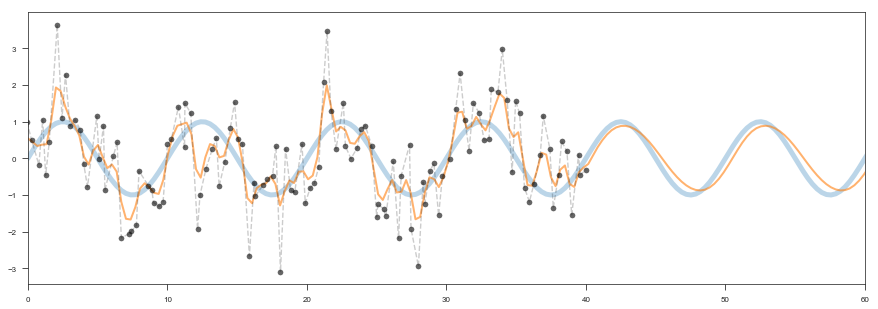

In [9]:
fig = plt.figure(1, figsize=(15, 5))

plt.plot(X, np.sin(X * (2 * np.pi) / 10), lw=5, alpha=0.3)
plt.plot(X, y_mean, lw=2, alpha=0.6)

plt.plot(x_e, y_derr, 'ko', alpha=0.5)
plt.plot(x_e, y_derr, 'ko--', alpha=0.2)

plt.xlim([0, 60])
#plt.ylim([-2.5, 2.5])

# 3. Results

 Oscillatory motions of boundary-layer clouds can be seen at multiple scales. Many cumulus clouds can be described as a series of pulsating plumes, and this periodic nature has long been thought to be a crucial factor in understanding the life cycle of moist convection (Malkus, QJR, 1952; Zhao and Austin, JAS, 2005a, 2005b; Heus et al., JGR, 2009). The cloud size distribution, a macro-scale property of cloud fields, has also been observed to oscillate over time; clouds grow larger and deeper as smaller plumes aggregate, which is followed by a breakup of larger clouds and an abundance of smaller clouds (Feingold et al., JGR, 2017).

## 3.1. Oscillations in Cloud Size Distribution 

 First, we examine the observations of oscillating size distribution in a shallow cumulus field according to Feingold et al. (2017). In the literature, it is well known that the cloud size distribution can be well described by a negative power law distribution as a function of cloud size $a$, or $$P(a) = A a^b,$$  where $P(a)$ is the number of clouds between cloud area $a$ and $d\,a$ in units of m$^2$.
 
 Feingold et al. (2017) report that the size distribution parameters oscillate at two distinctive periods, one at $\approx 80$ min and one at $\approx 15$ min, using the Fourier spectral analysis.
 
 The following is the result of running the Fourier spectral analysis on our BOMEX data; as reported by Feingold et al. (2017), we do observe two peaks at a periodicity of $\approx 80$ min and one at $\approx 15$ min, but we also see another peak at $\approx 45$ min. At the moment at least, it is not clear if it relates to some physical attributes of the cloud size distribution or to some convective timescales inherent in BOMEX case.

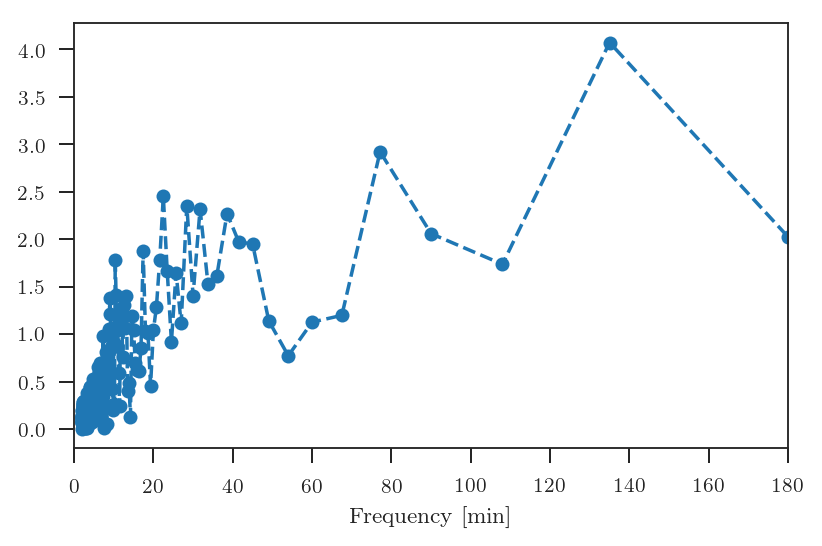

In [10]:
Image('../png/plot_fft.png')

 In order to study the oscillations in the cloud size distribution, we use our BOMEX dataset to obtain the size distribution at each timestep and apply Gaussian process regression method. The following is a log-log plot of the cloud size distribution at 5 hours into simulation.

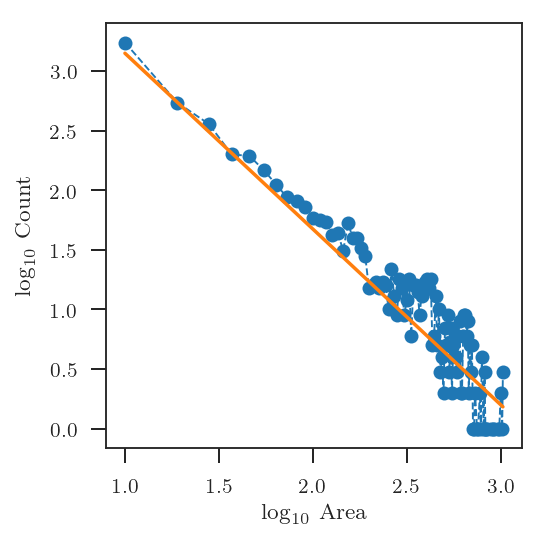

In [11]:
Image('../png/get_cloud_size_dist.png')

In [12]:
#coef_: -0.82337, int_: 2.65854

 Since we are working on a log-log plot, we estimated the slope and the intercept of the cloud size distribution, which gives us $b$ (coefficient/slope) and $A$ (intercept) for the power law relationship.
 
 The slope and the intercept is estimated by a ridge regression method.
 
 It has to be noted that due to the nature of the analysis, there is a lot of variance involved in preparing the timeseries dataset. There are uncertainties in measuring the size of the individual cloud, in determining the right bin size to come up with the cloud size distribution, and in estimating the slope (and intercept) of that distribution. As a result, we expect that the observed timeseries will be very noisy. We could test the sensitivity of some parameters (especially the bin size and the weighting function) in the future.
 
 We repeated the regression process for our 3-hour dataset, and plotted the timeseries of the slope $b$ for the cloud size distribution during that period. I have also repeated the following analysis for the intercept $A$, and confirmed that the two variables are highly correlated to each other, but the results for the intercept $A$ is skipped for brevity. We will focus on the oscillatory nature of the slope of the cloud size distribution. 

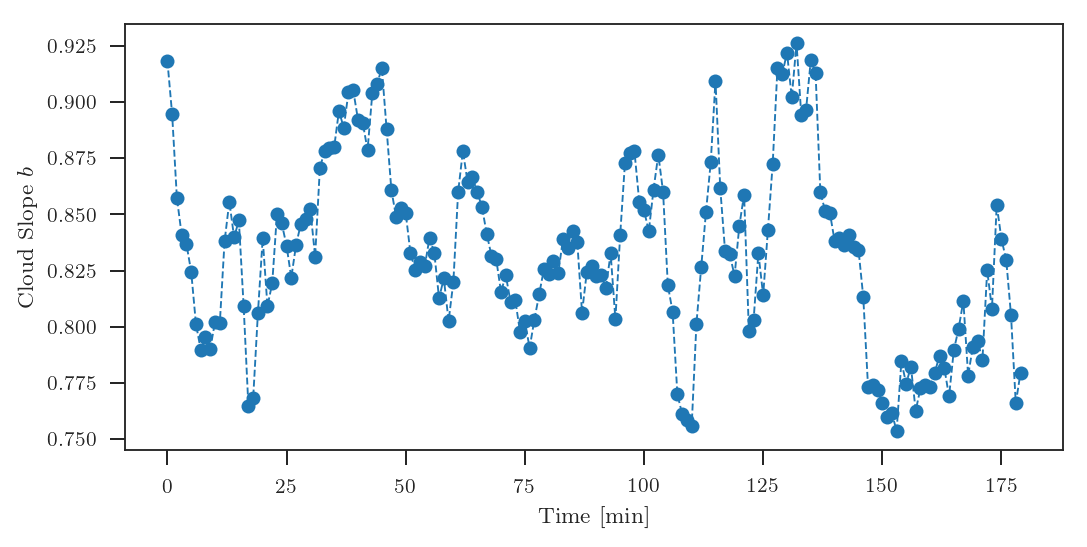

In [13]:
Image('../png/cloud_slope_timeseries.png')

 As we can see from the timeseries plot of (the slope of) the cloud size distribution, it is not immediately obvious if the slope of the cloud size distribution has any consistent oscillatory tendencies. Still, that was also the case in the sample wave function in Section 2, so it might be worth trying to use the GP regression method to detect the periodicity in the noisy data.
 
 As we have already done in Section 2, I have de-trended the timeseries data above and used *scikit-learn* to apply Gaussian process regression method. Knowing that we have just de-trended the timeseries, I used the *rational quadratic* kernel to account for the local variation, and used two periodic kernels to account for the two periods seen in the Fourier spectral diagram. I have also tested using three for the smallest timescale, most likely corresponding to the eddy turnover timescale at $15$ minutes, but it does not seem to affect the log-marginal likelyhood. So we will ignore it for now.

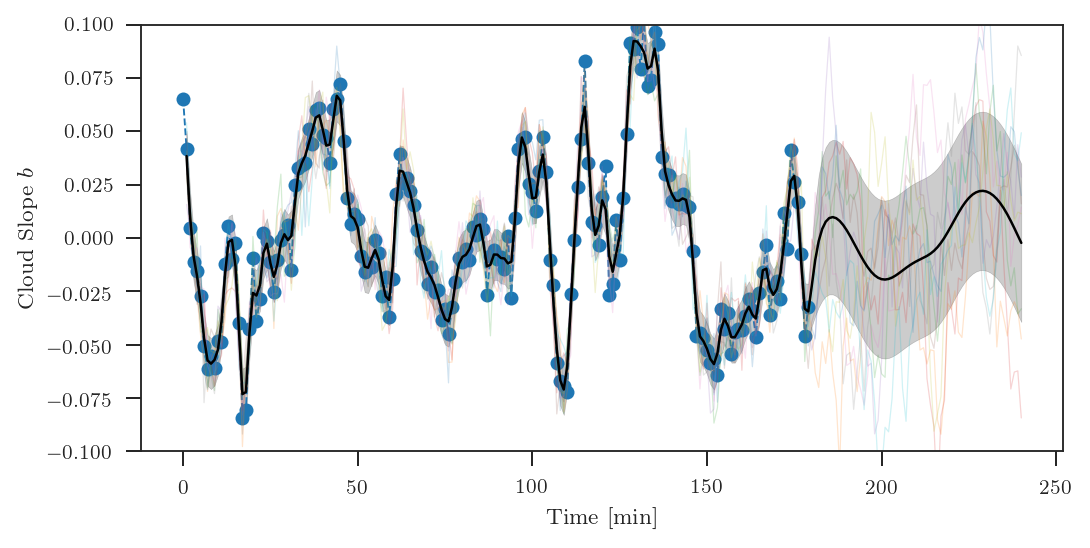

In [14]:
Image('../png/plot_slope_timeseries_BOMEX.png')

0.00316**2 * RBF(length_scale=1e+05) 
+ 0.0339**2 * RationalQuadratic(alpha=0.884, length_scale=2.31) 
+ 0.557**2 * WhiteKernel(noise_level=0.000311) 
+ 0.00316**2 * ExpSineSquared(length_scale=245, periodicity=77.9) 
+ 0.0195**2 * ExpSineSquared(length_scale=1.04, periodicity=47.1)

 We have added the SE kernel (RBF in *scikit-learn*) as after a few iterations of hyperparameter optimization, it became evident that GP regression was insisting on a long-term trend in the timeseries. This is most likely because the de-trending algorithm isn't aggressive enough. We can probably do better with a custom de-trending function, but for now, simply adding a very smooth, long-term trend to the kernel seems to resolve the issue.
 
 As we can see from the hyperparameters of the posterier distribution, the GP regression method seems to converge towards a periodicity at $77.9$ minutes and another at $47.1$ minutes. We also observe that adding a periodic covariance function to account for the $15$-minute oscillation (according to the eddy turnover timescale) gives a periodicity of $16$ minutes, which is not shown for brevity.
 
 The former periodicity seems to correspond well to the periodicity of roughly $80$ minutes reported in Feingold et al. (2017). However, it is clear that there is another underlying oscillation in our timeseries data at $\approx 45$ minutes, although it is not obvious as to where it is coming from. 
 
 At this point, we can try to visualize the underlying oscillatory motions by *forcing* the GP priors to be very smooth functions (using the SE kernel) which are governed mainly by the periodic covariance function. This is not meant to be a regression step, but merely for the sake of visualization, as it helps us see how good the estimated periodic oscillation really is against noisy observations.
 
 The following figures show the result of such psudo-regression using smooth periodic kernels on our timeseries data. The prior periodicities were set roughly ($T = 45$ minutes and $T = 75$ minutes, respectively) but they quickly converged towards the properly estimated values.

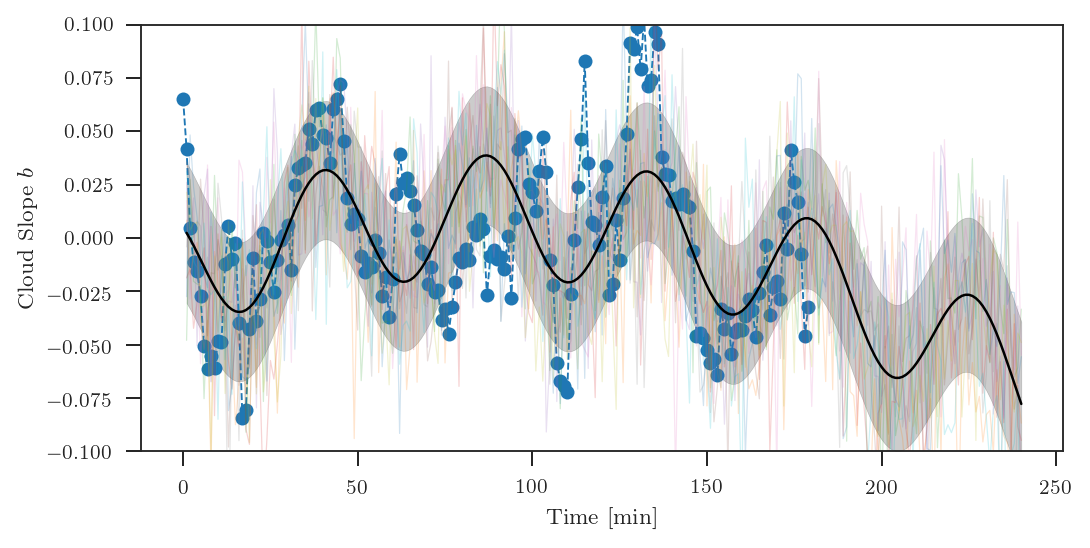

In [16]:
Image('../png/plot_slope_timeseries_45min.png')

RBF(length_scale=523) 
+ WhiteKernel(noise_level=0.00103) 
+ ExpSineSquared(length_scale=47.9, periodicity=46.5)

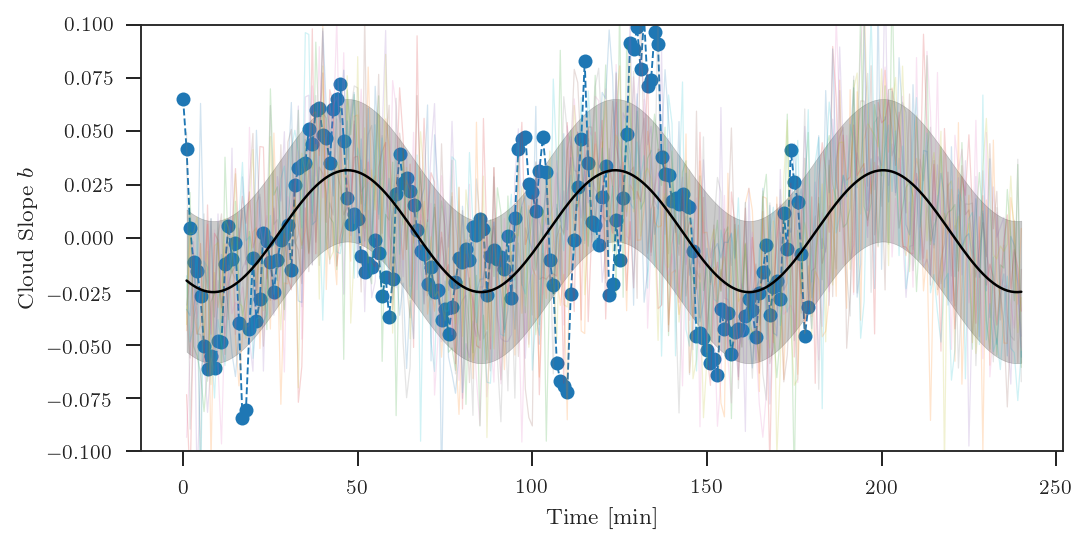

In [17]:
Image('../png/plot_slope_timeseries_75min.png')

RBF(length_scale=1e+05) 
+ WhiteKernel(noise_level=0.0011) 
+ ExpSineSquared(length_scale=48.5, periodicity=76.7)

 It is not quite obvious as to which estimate is *right*, especially because the log-marginal likelihood values are both quite similar ($\approx 350$). Perhaps it is because we do not have a long enough timeseries data, as in Feingold et al. (2017), the authors observed the changes in the cloud size distribution over a 6-hour period. Perhaps there is indeed a mechanism that is driving the changes in the cloud size distribution over this $45$-minute timespan, although we do not know what it might be.
 
 It should be noted, however, that the short-period oscillation predicts that even for this de-trended data, the cloud size distribution will fall rapidly over time. This is indeed the case in BOMEX (*cf.* Figure 9 in Feingold et al. (2017)), and repeating this analysis for a longer timeseries will definitely help us come up with a better periodicity estimate.
 
 This would give us an interesting insight in the development of macroscopic as well as microscopic properties of the cloud field. As we have seen before, the macroscopic properties of the cloud field (the slope of the cloud size distribution in this case) can be used to model the microscopic properties of the individual clouds in the domain (mass flux $\mathcal{M}$ and entrainment rate $\mathcal{E}$), as shown below.

# 4. References

Blyth, A. M., S. G. Lasher-Trapp, and W. A. Cooper, 2005: A study of thermals in cumulus clouds. *Q. J. R. Meteorol*. Soc, **131**, 1171–1190, doi:10.1256/qj.03.180.

Feingold, G., J. Balsells, F. Glassmeier, T. Yamaguchi, J. Kazil, and A. McComiskey, 2017: Analysis of albedo versus cloud fraction relationships in liquid water clouds using heuristic models and large eddy simulation. *J. Geophys. Res. Atmos*, **122**, 7086–7102, doi:10.1002/2017JD026467.

French, J. R., G. Vali, and R. D. Kelly, 1999: Evolution of small cumulus clouds in Florida: observations of pulsating growth. *Atmos. Res*, **52**, 143–165, doi:10.1016/s0169-8095(99)00024-1.

Grinnell, S. A., C. S. Bretherton, A. M. Fraser, and D. E. Stevens, 1996: Vertical Mass Flux Calculations in Hawaiian Trade Cumulus Clouds from Dual-Doppler Radar. *J. Atmos. Sci*, **53**, 1870–1886, doi:10.1175/1520-0469(1996)053<1870:vmfcih>2.0.co;2.

Heus, T., H. J. J. Jonker, H. E. A. Van den Akker, E. J. Griffith, M. Koutek, and F. H. Post, 2009: A statistical approach to the life cycle analysis of cumulus clouds selected in a virtual reality environment. *J. Geophys. Res*, **114**, 97, doi:10.1029/2008JD010917.

Malkus, J. S., 1952: The slopes of cumulus clouds in relation to external wind shear. *Q. J. R. Meteorol. Soc*, **78**, 530–542, doi:10.1002/qj.49707833804.

Scorer, R. S., and F. H. Ludlam, 1953: Bubble theory of penetrative convection. *Q. J. R. Meteorol. Soc*, **79**, 94–103, doi:10.1002/qj.49707933908.

Zhao, M., and P. H. Austin, 2005a: Life Cycle of Numerically Simulated Shallow Cumulus Clouds. Part I: Transport. *J. Atmos. Sci*, **62**, 1269–1290, doi:10.1175/JAS3414.1.

Zhao, M., and P. H. Austin, 2005b: Life Cycle of Numerically Simulated Shallow Cumulus Clouds. Part II: Mixing Dynamics. *J. Atmos. Sci*, **62**, 1291–1310, doi:10.1175/jas3415.1.